# Import the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import json

# Get the bitcoin prices into a DataFrame

In [3]:
times=[]
prices=[]
for year in range(2017,2021):
    year=str(year)
    months=['01','02','03','04','05','06','07','08','09','10','11','12']
    for i in range(11):
        start=year+'-'+months[i]+'-01'
        end=year+'-'+months[i+1]+'-01'
        url = 'https://api.nomics.com/v1/currencies/sparkline?key=63a6fb7bcdc2345fac6baed3afd92150&ids=BTC&start='+start+'T00%3A00%3A00Z&end='+end+'T00%3A00%3A00Z'
        k=urllib.request.urlopen(url).read()
        o=json.loads(k)
        times+=o[0]['timestamps']
        prices+=o[0]['prices']
    start=year+'-'+'12'+'-02'
    end=year+'-'+'12'+'-31'
    url = 'https://api.nomics.com/v1/currencies/sparkline?key=63a6fb7bcdc2345fac6baed3afd92150&ids=BTC&start='+start+'T00%3A00%3A00Z&end='+end+'T00%3A00%3A00Z'
    k=urllib.request.urlopen(url).read()
    o=json.loads(k)
    times+=o[0]['timestamps']
    prices+=o[0]['prices']
year=str(2021)
months=['01','02','03','04','05']
for i in range(4):
    start=year+'-'+months[i]+'-01'
    end=year+'-'+months[i+1]+'-01'
    url = 'https://api.nomics.com/v1/currencies/sparkline?key=63a6fb7bcdc2345fac6baed3afd92150&ids=BTC&start='+start+'T00%3A00%3A00Z&end='+end+'T00%3A00%3A00Z'
    k=urllib.request.urlopen(url).read()
    o=json.loads(k)
    times+=o[0]['timestamps']
    prices+=o[0]['prices']
start=year+'-'+months[4]+'-01'
end=year+'-'+months[4]+'-18'
url = 'https://api.nomics.com/v1/currencies/sparkline?key=63a6fb7bcdc2345fac6baed3afd92150&ids=BTC&start='+start+'T00%3A00%3A00Z&end='+end+'T00%3A00%3A00Z'
k=urllib.request.urlopen(url).read()
o=json.loads(k)
times+=o[0]['timestamps']
prices+=o[0]['prices']

dict1={'timestamps':times,'value':prices}
dfp=pd.DataFrame(dict1)
dfp.drop_duplicates(keep='first',inplace=True)
dfp.reset_index(inplace=True)
dfp.drop(['index'],axis=1,inplace=True)
df1=dfp.reset_index()['value']
df1=pd.to_numeric(df1)

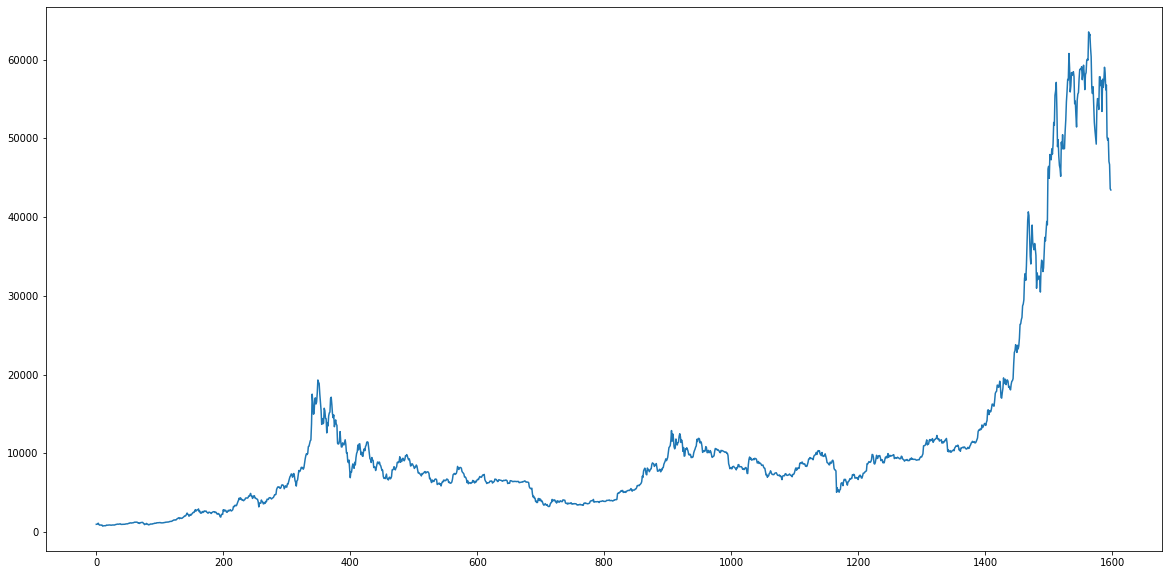

In [4]:
plt.figure(figsize=(20,10))
plt.plot(df1)

LSTM's are sensitive to scale. We have to adress this issue.
Let's use a scale factor of 100000

In [5]:
dfuse=df1/100000

In [7]:
training_size=int(len(dfuse)*0.97)
test_size=len(dfuse)-training_size
dfuse=np.array(dfuse).reshape(-1,1)
train_data=(dfuse[0:training_size,:])
test_data=(dfuse[training_size:len(dfuse),:1])

In [8]:
training_size,test_size

(1551, 48)

Prepare the data

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [13]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [33]:
print(X_train.shape), print(y_train.shape)

(1530, 20, 1)
(1530,)


(None, None)

In [34]:
print(X_test.shape), print(ytest.shape)

(27, 20, 1)
(27,)


(None, None)

# Model Creation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [46]:
model=Sequential()
model.add(LSTM(40,return_sequences=True,input_shape=(20,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(30))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 50)            18200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 40)            14560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)               

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
y_train.shape

(1530,)

In [48]:
model.fit(X_train,y_train,epochs=30,batch_size=64,verbose=1)

Epoch 1/30
24/24 [==============================] - 8s 27ms/step - loss: 0.0096
Epoch 2/30
24/24 [==============================] - 1s 24ms/step - loss: 0.0013
Epoch 3/30
24/24 [==============================] - 1s 25ms/step - loss: 6.9531e-04
Epoch 4/30
24/24 [==============================] - 1s 24ms/step - loss: 7.0753e-04
Epoch 5/30
24/24 [==============================] - 1s 25ms/step - loss: 6.3529e-04
Epoch 6/30
24/24 [==============================] - 1s 23ms/step - loss: 6.1446e-04
Epoch 7/30
24/24 [==============================] - 1s 24ms/step - loss: 8.4189e-04
Epoch 8/30
24/24 [==============================] - 1s 23ms/step - loss: 6.2431e-04
Epoch 9/30
24/24 [==============================] - 1s 25ms/step - loss: 5.5202e-04: 0s - loss: 4.90
Epoch 10/30
24/24 [==============================] - 1s 25ms/step - loss: 7.2084e-04
Epoch 11/30
24/24 [==============================] - 1s 24ms/step - loss: 4.9129e-04
Epoch 12/30
24/24 [==============================] - 1s 26ms/step

# Predictions

In [49]:
yout=model.predict(X_test)

In [50]:
yout1=model.predict(X_train)

Train Data

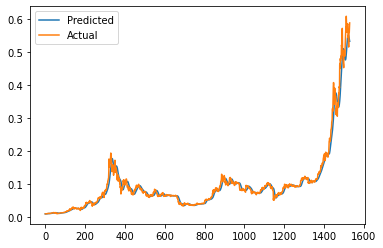

In [51]:
plt.plot(yout1)
plt.plot(y_train)
plt.legend(['Predicted','Actual'])

Test Data

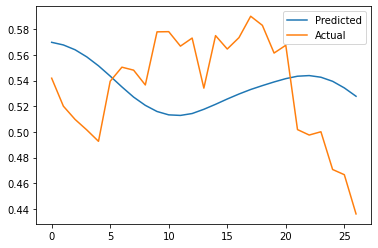

In [52]:
plt.plot(yout)
plt.plot(ytest)
plt.legend(['Predicted','Actual'])

# Save the model

In [60]:
from keras.models import load_model
model.save("bitcoin.h5")

In [61]:
loaded_model = load_model("bitcoin.h5")

In [82]:
X_test.shape

(27, 20, 1)

# Web App

In [ ]:
from pywebio.output import *
from pywebio.input import * 
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd
import urllib.request
import json
from pywebio.platform.flask import webio_view
from pywebio import STATIC_PATH
from flask import Flask, send_from_directory
from keras.models import load_model
app=Flask(__name__)
def predict():
    def forecastbtc(prices,days):
        loaded_model = load_model("bitcoin.h5")
        use=np.array(prices[-21:-1])
        use=use.reshape(1,20,1)
        use=use/100000
        predicts=float(loaded_model.predict(use))*100000
        scale=(prices[-1]+1000)/predicts
        final=[]
        day=0
        while(day<days):
            day+=1
            use=np.array(prices[-20:])
            use=use.reshape(1,20,1)
            use=use/100000
            predicts=float(loaded_model.predict(use))*100000
            final.append(predicts*scale)
            prices.append(predicts*scale)
        return final
    today=str(datetime.datetime.today())[:10]
    past=str(datetime.datetime.today()-datetime.timedelta(days=30))[:10]
    put_markdown('The Cryptocurrency')
    put_text("Use this app to know the statistics of Bitcoin and Dogecoin.")
    with popup("Caution!"):
        put_text("The predictions are just for educational purposes, please refrain from relying upon it!")
    condition = select("Choose the type of Cryptocurrency", ['Bitcoin', 'Dogecoin'])
    with popup("Note"):
        put_text("We are purely relying upon the data provideb by various websites, we are not responsible for any mistakes prent in the data.")
    if condition=='Bitcoin':
        url = 'https://api.nomics.com/v1/currencies/sparkline?key=63a6fb7bcdc2345fac6baed3afd92150&ids=BTC&start='+past+'T00%3A00%3A00Z&end='+today+'T00%3A00%3A00Z'
        k=urllib.request.urlopen(url).read()
        o=json.loads(k)
        times=o[0]['timestamps']
        times=list(map(lambda x:x[:10],times))
        prices=o[0]['prices']
        prices=list(map(float,prices))
        plt.figure(figsize=(20,5))
        plt.plot(times,prices)
        plt.title('Bitcoinprice vs time')
        plt.xticks(rotation=90)
        plt.xlabel('time')
        plt.ylabel('price')
        plt.savefig('btcprice.png')
        put_image(open('btcprice.png', 'rb').read(),width='3000px')
        days1 = select("How many days into the future you want the predictions.", [0,1,2,3,4,5,6,7,8,9,10])
        with popup("Caution!"):
            put_text("The predictions are just for educational purposes, prices are lot dependent on the external factors!")
        predicted=forecastbtc(prices,days1)
        plt.figure(figsize=(20,5))
        plt.plot([i for i in range(1,days1+1)],predicted)
        plt.title('Bitcoinprice prediction vs time')
        plt.xticks(rotation=90)
        plt.xlabel('time')
        plt.ylabel('price')
        plt.savefig('btcpricepred.png')
        put_image(open('btcpricepred.png', 'rb').read(),width='3000px')
app.add_url_rule('/tool','webio_view',webio_view(predict),methods=["GET","POST","OPTIONS"])
app.run(host='Localhost',port=80)
#visit http://localhost/tool